# Preparation

In [161]:
import datetime
import iminuit
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
import seaborn as sns
import warnings

%load_ext ipycache
%load_ext watermark
%watermark
%watermark -p pandas,scipy

sns.set_style('darkgrid')
sns.set_context('notebook')

cachedir = '/scratch/cache/'
memory = joblib.Memory('cachedir')

The ipycache extension is already loaded. To reload it, use:
  %reload_ext ipycache
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2019-04-17T16:06:38+02:00

CPython 3.6.8
IPython 7.2.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.4.176-96-default
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
pandas 0.24.2
scipy 1.2.0


In [2]:
results = pd.DataFrame()

# atmospheric C14

In [3]:
xp = np.array([ 1891.5, 1892.5, 1893.5, 1894.5, 1895.5, 1896.5, 1897.5, 1898.5, 1899.5, 1900.5, 1901.5, 1902.5, 1903.5, 1904.5, 1905.5, 1906.5, 1907.5, 1908.5, 1909.5, 1910.5, 1911.5, 1912.5, 1913.5, 1914.5, 1915.5, 1916.5, 1917.5, 1918.5, 1919.5, 1920.5, 1921.5, 1922.5, 1923.5, 1924.5, 1925.5, 1926.5, 1927.5, 1928.5, 1929.5, 1930.5, 1931.5, 1932.5, 1933.5, 1934.5, 1935.5, 1936.5, 1937.5, 1938.5, 1939.5, 1940.5, 1941.5, 1942.5, 1943.5, 1944.5, 1945.5, 1946.5, 1947.5, 1948.5, 1949.5, 1950.5, 1951.5, 1952.5, 1953.5, 1954.5, 1955.5, 1956.5, 1957.5, 1958.5, 1959.5, 1960.5, 1961.5, 1962.5, 1963.5, 1964.5, 1965.5, 1966.5, 1967.5, 1968.5, 1969.5, 1970.5, 1971.5, 1972.5, 1973.5, 1974.5, 1975.5, 1976.5, 1977.5, 1978.5, 1979.5, 1980.5, 1981.5, 1982.5, 1983.5, 1984.5, 1985.5, 1986.5, 1987.5, 1988.5, 1989.5, 1990.5, 1991.5, 1992.5, 1993.5, 1994.5, 1995.5, 1996.5, 1997.5, 1998.5, 1999.5, 2000.5, 2001.5, 2002.5, 2003.5, 2003.963938,  2004.421821,  2004.879704, 2005.337587,  2005.79547 ,  2006.253353,  2006.711236, 2007.169119,  2007.627002,  2008.084885,  2008.542768, 2009.000651,  2009.458534,  2009.916417,  2010.3743  , 2010.3743  ,  2010.626   ,  2011.125   ,  2011.626   , 2012.125   ,  2012.626   ,  2013.125   ,  2013.626   , 2014.125   ,  2014.626   ,  2015.125   ,  2015.625   , 2016.125   ,  2016.625   ,  2020.      ])
fp = np.array([-0.002     , -0.002     , -0.002     , -0.002     , -0.002     , -0.00233   , -0.00267   , -0.003     , -0.00333   , -0.00367   , -0.004     , -0.00433   , -0.00467   , -0.005     , -0.00533   , -0.00567   , -0.006     , -0.00633   , -0.00667   , -0.007     , -0.00733   , -0.00767   , -0.008     , -0.00833   , -0.00867   , -0.009     , -0.00933   , -0.00967   , -0.01      , -0.01033   , -0.01067   , -0.011     , -0.01133   , -0.01167   , -0.012     , -0.01233   , -0.01267   , -0.013     , -0.01333   , -0.01367   , -0.014     , -0.01433   , -0.01467   , -0.015     , -0.01533   , -0.01567   , -0.016     , -0.01633   , -0.01667   , -0.0202    , -0.0194    , -0.0196    , -0.0225    , -0.0217    , -0.0221    , -0.0216    , -0.0211    , -0.0223    , -0.0246    , -0.0248    , -0.0248    , -0.0249    , -0.0239    , -0.0211    , -0.0082    , 0.0265    ,  0.073     ,  0.1402    ,  0.228     ,  0.2123    , 0.2216    ,  0.3585    ,  0.7183    ,  0.8357    ,  0.7563    , 0.6919    ,  0.6236    ,  0.5645    ,  0.5454    ,  0.5291    , 0.4994    ,  0.4656    ,  0.4186    ,  0.4008    ,  0.3698    , 0.3525    ,  0.3339    ,  0.3258    ,  0.2958    ,  0.2645    , 0.2567    ,  0.2383    ,  0.2242    ,  0.2093    ,  0.2013    , 0.1911    ,  0.1826    ,  0.1734    ,  0.1635    ,  0.1525    , 0.1429    ,  0.1364    ,  0.1284    ,  0.1221    ,  0.1155    , 0.1099    ,  0.1043    ,  0.0981    ,  0.09      ,  0.0866    , 0.0807    ,  0.0749    ,  0.0689    ,  0.06349874,  0.06145905, 0.0597412 ,  0.05822747,  0.05641489,  0.05479531,  0.05364811, 0.05205465,  0.05067073,  0.04927897,  0.04788014,  0.04647508, 0.04506462,  0.04364948,  0.04223027,  0.04223027,  0.0403    , 0.0347    ,  0.0371    ,  0.0312    ,  0.0299    ,  0.0193    , 0.0219    ,  0.0182    ,  0.018     ,  0.0116    ,  0.0129    , 0.0096    ,  0.0097    ,  0.0097    ])
C_atm = lambda x: sp.interp(x, xp+1, fp)

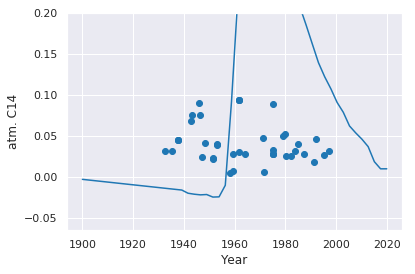

In [216]:
tt = np.linspace(1900, 2020)
plt.plot(tt, C_atm(tt))
plt.xlabel('Year')
plt.ylabel('atm. C14')
plt.scatter(datasets['hepatocytes']['Dbirth'], datasets['hepatocytes']['d14C'])
plt.ylim(None, 0.2)
plt.show()

# Ploidy

In [5]:
ploidy_data = pd.read_excel('../../data/kudryavtsev_et_al_1993_table_2.xlsx')

In [6]:
ploidy_data['age'] = ploidy_data[['age_min', 'age_max']].mean(axis='columns')
ploidy_data /= 100.0
ploidy_data['age'] *= 100

In [7]:
ploidy = sp.interpolate.UnivariateSpline(ploidy_data['age'].values,
                                ploidy_data['2C_mean'].values,
                               ext=3)

In [8]:
ploidy2x2 = sp.interpolate.UnivariateSpline(ploidy_data['age'].values,
                                ploidy_data['2Cx2_mean'].values,
                               ext=3)

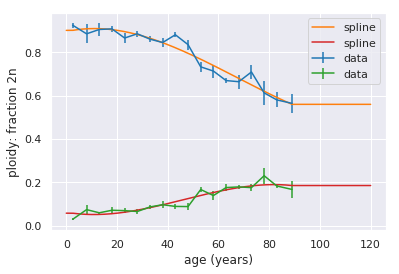

In [9]:
tt = np.linspace(0, 120, 1000)
plt.errorbar(ploidy_data['age'].values, ploidy_data['2C_mean'].values, ploidy_data['2C_sem'].values, label='data')
plt.plot(tt, ploidy(tt), label='spline')

plt.errorbar(ploidy_data['age'].values, ploidy_data['2Cx2_mean'].values, ploidy_data['2Cx2_sem'].values, label='data')
plt.plot(tt, ploidy2x2(tt), label='spline')

plt.xlabel('age (years)')
plt.ylabel('ploidy: fraction 2n')
plt.legend()
plt.show()

# Read patient data

In [10]:
data = pd.read_pickle('../../results/C14data_liver_samples_2019-04-05.pkl')

Filter samples with error_measurement too big:

In [11]:
data = data[data['error_measurement'] < 0.5*0.03]

In [12]:
data[['sample', 'pathology']].head()

,sample,pathology
0,ND380,N
1,ND388,N
2,ND381,N
3,ND382,N
4,ND022,N


Calculate mean values for repeated measurements:

In [13]:
c14_patient_data = data.groupby(['type', 'sample']).mean().dropna(how='all').reset_index()
c14_patient_data = c14_patient_data.merge(data[['sample', 'pathology', 'ploidy']].drop_duplicates())

In [14]:
c14_patient_data.head()

,type,sample,Dbirth,Dcoll,d14C,error_measurement,N_cells,subject_age,pathology,ploidy
0,hepatocyte,HL#11,1975.333333,2019.75,0.0279,0.006625,44.5,44.416667,T,2n4n
1,hepatocyte,HL#11,1975.333333,2019.75,0.0279,0.006625,44.5,44.416667,T,2n
2,hepatocyte,HL#11,1975.333333,2019.75,0.0279,0.006625,44.5,44.416667,T,4n
3,non-hepatocyte,HL#11,1975.333333,2019.75,-0.0335,0.008800,36.0,44.416667,T,2n4n
4,non-hepatocyte,HL#11,1975.333333,2019.75,-0.0335,0.008800,36.0,44.416667,T,2n


# SSE & log-likelihood

In [15]:
def SSE(p, model, data):
    model_data = model(data['Dbirth'].values, 
                    data['Dcoll'].values, 
                       data['ploidy'].values, 
                    *p)
    sse = np.sum((model_data - data['d14C'].values)**2)
    return sse    

In [16]:
def Sigma(p, model, data):
    sse = SSE(p, model, data)
    n = len(data)
    sigma = np.sqrt(sse/n)
    return sigma

In [17]:
def Nloglike(p, model, data):
    sse = SSE(p, model, data)
    n = len(data)
    sig = np.sqrt(sse/n)
    loglike = -n/2 * np.log(2*np.pi) - n/2 * np.log(sig**2) - 1 / (2*sig**2) * sse
    return -loglike

In [100]:
def migrad(x0, model, data, error=0.1, limit=None):
    M = iminuit.Minuit.from_array_func(lambda x0: Nloglike(x0, model, data),
                                       x0,
                                       error=error,
                                       limit=limit,
                                       errordef=0.5,
                                       name=iminuit.describe(model)[3:],
                                      print_level=0)
    import scipy.misc
    try:
        M.migrad()
        try:
            corr = M.matrix(correlation=True)
        except:
            corr = np.nan
        return M.values.values(), M.errors.values(),  M.fval, M.migrad_ok(), corr
    except:
        raise
        return np.nan*np.ones_like(x0), M.errors.values(), np.inf, M.migrad_ok(), np.nan

In [110]:
@memory.cache(ignore=['processes'])
def multistart_migrad(modelname, ranges_, dataset, error=0.1, limit=None, n=100, processes=8, seed=42, step_=2):
    global step
    step = step_
    
    data = datasets[dataset]
    
    np.random.seed(seed)
    model = eval(modelname)
    x0s = np.random.uniform(ranges_[0], ranges_[1], (n, len(ranges_[0])))
    
    res = joblib.Parallel(n_jobs=processes)(joblib.delayed(migrad)(x0, model, data, error, limit) for x0 in x0s)
    res = [[x0] + list(r) for x0, r in zip(x0s, res)]
    res = pd.DataFrame(res, columns=['x0', 'values', 'errors', 'fval', 'valid', 'corr'])
    res['n'] = len(data)
    res['fval'] = res['fval'].astype('float')
    res['valid'] = res['valid'].astype('bool')
    res.columns.name = model.__name__
    return res[['x0', 'fval', 'values', 'errors', 'corr', 'valid', 'n']]

In [196]:
def summarise(res):
    """ Summarise the fit results """
    print(res.columns.name)
    plt.scatter(res['fval'].rank(), res['fval'], c=res['valid'], vmin=0, vmax=1)
    plt.colorbar()
    plt.show()
    best_res = res.loc[res['fval'].idxmin()]
    p_names = iminuit.util.describe(eval(res.columns.name))[3:]
    print('Parameter values')
    for name, value, error in zip(p_names, best_res['values'], best_res['errors']):
        if name.startswith('log'):
            print(f'{name[3:]}: {np.exp(value):.3g} [{np.exp(value-error):.3g}, {np.exp(value+error):.3g}]')
        else:
            print(f'{name}: {value:3g} +- {error:3g}')
    print()
    
    result = pd.Series([-best_res['fval'], len(p_names)+1, best_res['n']], index=['loglike', 'k', 'n'])
    result['cAIC'] = 2 * result['k'] - \
                     2 * result['loglike'] + \
                    (2*result['k']**2 + 2*result['k'])/(result['n']-result['k']-1)
    global results
    try:
        results.loc[res.columns.name] = result
    except:
        results=pd.DataFrame(columns=['loglike', 'k', 'n', 'cAIC'])
        results.loc[res.columns.name] = result
    return results

# Defining the models

In [21]:
def sol(rhs, Dbirth, Dcoll):
    def rhs2(t, c):
        return np.where(t<=Dcoll-Dbirth, rhs(t, c), 0)
                 
    C_init = C_atm(Dbirth)
    if C_init.shape==():
        C_init = np.array([C_init])
    
    sol = sp.integrate.solve_ivp(fun=rhs2,
                                 t_span=(0, np.max(Dcoll-Dbirth)),
                                 t_eval=[np.max(Dcoll-Dbirth)],
                                 y0=C_init,
                                vectorized=False,
                                max_step=step,
                                first_step=step,
                                rtol=np.inf,
                                atol=np.inf,
                                method='RK45'
                                )
    return sol.y[:,0]

## Scenario I1

In [22]:
def I1(Dbirth, Dcoll, Dploidy, loglam):
    lam = np.exp(loglam)

    def rhs(t, c):
            return lam * (C_atm(t+Dbirth) - c)

    return sol(rhs, Dbirth, Dcoll)

## I1T_step

In [23]:
def I1_lamfun(Dbirth, Dcoll, lamfun):
    def rhs(t, c):
            return lamfun(t) * (C_atm(t+Dbirth) - c)

    return sol(rhs, Dbirth, Dcoll)

In [206]:
def I1T_step(Dbirth, Dcoll, loglam1, loglam2, t_step):   
    return I1_lamfun(Dbirth, Dcoll, lambda t: np.where(t < t_step, np.exp(loglam1), np.exp(loglam2)))

## I1T_lin

In [25]:
def I1T_lin(Dbirth, Dcoll, Dploidy, loglam0, loglam100):   
    return I1_lamfun(Dbirth, Dcoll, lambda t: np.interp(t, [0, 100], [np.exp(loglam0), np.exp(loglam100)]))

## Full Ploidy models

In [26]:
def solP(rhs, Dbirth, Dcoll, Dploidy):
    def rhs2(t, c):
        return np.where(t<=np.append(Dcoll-Dbirth, Dcoll-Dbirth), rhs(t, c), 0)
    
    C_init = C_atm(Dbirth)
    C_init = np.append(C_init, C_init)
    
    sol = sp.integrate.solve_ivp(fun=rhs2,
                                 t_span=(0, np.max(Dcoll-Dbirth)),
                                 t_eval=[np.max(Dcoll-Dbirth)],
                                 y0=C_init,
                                vectorized=False,
                                max_step=step,
                                first_step=step,
                                rtol=np.inf,
                                atol=np.inf,
                                method='RK45'
                                )
    c = sol.y[:,0]
    c2 = c[:int(len(c)/2) ]
    c4 = c[ int(len(c)/2):]
    c24 = np.vstack((c2, c4))
    
    w = np.empty_like(c24)
    w[0, :] = ploidy(Dcoll-Dbirth)
    w[1, :] = 2*(1-w[0, :])
    w[0, Dploidy=='2n'] = ploidy(Dcoll[Dploidy=='2n']-Dbirth[Dploidy=='2n'])
    w[1, Dploidy=='2n'] = 2*ploidy2x2(Dcoll[Dploidy=='2n']-Dbirth[Dploidy=='2n'])

    w[0, Dploidy=='4n'] = 0
    w[1, Dploidy=='4n'] = 1
    
    return np.average(c24, weights=w, axis=0)

### Adjust death rates

In [27]:
def IPd(Dbirth, Dcoll, Dploidy, loglam2, loglam4, logk24, logk42):
    lam2 = np.exp(loglam2)
    lam4 = np.exp(loglam4)
    k24 = np.exp(logk24)
    k42 = np.exp(logk42)
    
    def rhs(t, c):
        c2 = c[:int(len(c)/2) ]
        c4 = c[ int(len(c)/2):]
        dtc2=lam2*(-c2 + C_atm(Dbirth + t)) + (2*(c2 - c4)*k42*(-1 + ploidy(t)))/ploidy(t)
        dtc4=lam4*(-c4 + C_atm(Dbirth + t)) - (k24*(c2 - 2*c4 + C_atm(Dbirth + t))*ploidy(t))/(2.*(-1 + ploidy(t)))
        return np.append(dtc2, dtc4)

    return solP(rhs, Dbirth, Dcoll, Dploidy)

### Adjust exchange rates

In [28]:
def IPk(Dbirth, Dcoll, Dploidy, loglam2, loglam4, logd2, logd4):
    lam2 = np.exp(loglam2)
    lam4 = np.exp(loglam4)
    d2 = np.exp(logd2)
    d4 = np.exp(logd4)
    
    def rhs(t, c):
        c2 = c[:int(len(c)/2) ]
        c4 = c[ int(len(c)/2):]
        dtc2=lam2*(c2 - 2*c4 + C_atm(Dbirth + t)) + (2*(c2 - c4)*(-d4 + lam4 - (d2 - d4 + lam4)*ploidy(t)))/ploidy(t)
        dtc4=(-c2 + c4)*lam4 + (lam2*(c2 - 2*c4 + C_atm(Dbirth + t))*ploidy(t))/(2.*(-1 + ploidy(t))) + ((c2 - 2*c4 + C_atm(Dbirth + t))*(-2*d4 + sp.misc.derivative(ploidy, t-Dbirth, 0.001) - (d2 - 2*d4)*ploidy(t)))/(2.*(-1 + ploidy(t)))
        return np.append(dtc2, dtc4)

    return solP(rhs, Dbirth, Dcoll, Dploidy)

### Adjust division rates

In [29]:
def IPl(Dbirth, Dcoll, Dploidy, logd2, logd4, logk24, logk42):
    d2 = np.exp(logd2)
    d4 = np.exp(logd4)
    k24 = np.exp(logk24)
    k42 = np.exp(logk42)
    
    def rhs(t, c):
        c2 = c[:int(len(c)/2) ]
        c4 = c[ int(len(c)/2):]
        dtc2=(2*c4*k42 - c2*sp.misc.derivative(ploidy, t-Dbirth, 0.001) - (c2*(d2 + k24) + 2*c4*k42)*ploidy(t) + C_atm(Dbirth + t)*(-2*k42 + sp.misc.derivative(ploidy, t-Dbirth, 0.001) + (d2 + k24 + 2*k42)*ploidy(t)))/ploidy(t)
        dtc4=(2*c4*(d4 + k42 - sp.misc.derivative(ploidy, t-Dbirth, 0.001)) - (c2*k24 + 2*c4*(d4 + k42))*ploidy(t) + C_atm(Dbirth + t)*(-2*(d4 + k42 - sp.misc.derivative(ploidy, t-Dbirth, 0.001)) + (2*d4 + k24 + 2*k42)*ploidy(t)))/(2.*(-1 + ploidy(t)))
        return np.append(dtc2, dtc4)

    return solP(rhs, Dbirth, Dcoll, Dploidy)

## Ploidy models with assumptions

### `IP_l40`: Ploidy model, lam4=0, d2=d4, k42=0

In [30]:
def IP_l40(Dbirth, Dcoll, Dploidy, loglam2):
    lam2 = np.exp(loglam2)
    
    def rhs(t, c):
        c2 = c[:int(len(c)/2) ]
        c4 = c[ int(len(c)/2):]
        dtc2=lam2*(-c2 + C_atm(Dbirth + t))
        dtc4=(sp.misc.derivative(ploidy, t-Dbirth, 0.001)*(c2 - 2*c4 + C_atm(Dbirth + t)))/(2.*(-1 + ploidy(t))) + (lam2*(c2 - 2*c4 + C_atm(Dbirth + t))*ploidy(t))/2.
        return np.append(dtc2, dtc4)
    
    return solP(rhs, Dbirth, Dcoll, Dploidy)

### `IP_l2l4`: Ploidy model - same death, division rate, k42=0

In [31]:
def IP_l2l4(Dbirth, Dcoll, Dploidy, loglam2):
    lam2 = np.exp(loglam2)
    
    def rhs(t, c):
        c2 = c[:int(len(c)/2) ]
        c4 = c[ int(len(c)/2):]
        dtc2=lam2*(-c2 + C_atm(Dbirth + t))
        dtc4=lam2*(-c4 + C_atm(Dbirth + t)) + (sp.misc.derivative(ploidy, t-Dbirth, 0.001)*(c2 - 2*c4 + C_atm(Dbirth + t)))/(2.*(-1 + ploidy(t)))
        return np.append(dtc2, dtc4)
    
    return solP(rhs, Dbirth, Dcoll, Dploidy)

### `IP_l40_step`: Ploidy model step - same death, lam4=0, k42=0

In [32]:
def IP_l40_lamfunc(Dbirth, Dcoll, Dploidy, lamfunc):
    
    def rhs(t, c):
        c2 = c[:int(len(c)/2) ]
        c4 = c[ int(len(c)/2):]
        dtc2=lamfunc(t)*(-c2 + C_atm(Dbirth + t))
        dtc4=(sp.misc.derivative(ploidy, t-Dbirth, 0.001)*(c2 - 2*c4 + C_atm(Dbirth + t)))/(2.*(-1 + ploidy(t))) + (lamfunc(t)*(c2 - 2*c4 + C_atm(Dbirth + t))*ploidy(t))/2.
        return np.append(dtc2, dtc4)
    
    return solP(rhs, Dbirth, Dcoll, Dploidy)

In [33]:
def IP_l40_step(Dbirth, Dcoll, Dploidy, loglam1, loglam2, t_step):   
    return IP_l40_lamfunc(Dbirth, Dcoll, Dploidy, lambda t: np.where(t <= t_step, np.exp(loglam1), np.exp(loglam2)))

In [34]:
def IP_l40_hill(Dbirth, Dcoll, Dploidy, loglam1, loglam2, t_step):  
    lam1 = np.exp(loglam1)
    lam2 = np.exp(loglam2)
    n=10
    return IP_l40_lamfunc(Dbirth, Dcoll, Dploidy, lambda t: lam1 + (-lam1+lam2) * t**n/(t_step**n + t**n))

In [35]:
def IP_l40_interp(Dbirth, Dcoll, Dploidy, loglam1, loglam2, t_step):  
    lam1 = np.exp(loglam1)
    lam2 = np.exp(loglam2)
    dt = 20.
    return IP_l40_lamfunc(Dbirth, Dcoll, Dploidy, lambda t: np.interp(t, [t_step-dt/2, t_step+dt/2], [lam1, lam2]))

### `IP_l40_lin`: Ploidy model step - same death, lam4=0, k42=0

In [107]:
def IP_l40_lin(Dbirth, Dcoll, Dploidy, loglam0, loglam100):  
    return IP_l40_lamfunc(Dbirth, Dcoll, Dploidy, lambda t: np.interp(t, [0, 100], [np.exp(loglam0), np.exp(loglam100)]))

### `IP_l2l4_step`: Ploidy model step - same death, division rate, k42=0

In [37]:
def IP_l2l4_lamfunc(Dbirth, Dcoll, Dploidy, lamfunc):
    
    def rhs(t, c):
        c2 = c[:int(len(c)/2) ]
        c4 = c[ int(len(c)/2):]
        dtc2=lamfunc(t)*(-c2 + C_atm(Dbirth + t))
        dtc4=lamfunc(t)*(-c4 + C_atm(Dbirth + t)) + (sp.misc.derivative(ploidy, t-Dbirth, 0.001)*(c2 - 2*c4 + C_atm(Dbirth + t)))/(2.*(-1 + ploidy(t)))
        return np.append(dtc2, dtc4)
    
    return solP(rhs, Dbirth, Dcoll, Dploidy)

In [38]:
def IP_l2l4_step(Dbirth, Dcoll, Dploidy, loglam1, loglam2, t_step):   
    return IP_l2l4_lamfunc(Dbirth, Dcoll, Dploidy, lambda t: np.where(t <= t_step, np.exp(loglam1), np.exp(loglam2)))

In [205]:
I1T_step(1920, 2000, '2n/4n', -2, -4, 50)

array([0.34897885])

In [205]:
I1T_step(1920, 2000, '2n/4n', -2, -4, 50)

array([0.34897885])

# Optimization

In [39]:
rate_min = np.log(1e-2)
rate_max = np.log(1)

In [40]:
ranges = {}
ranges['I1'] = [(rate_min, ), (rate_max, )]
ranges['I1T_step'] = [(rate_min, rate_min, 10), (rate_max, rate_max, 80)]
ranges['I1T_lin'] = [(rate_min, rate_min), (rate_max, rate_max)]
ranges['IPd'] = [(rate_min, rate_min, rate_min, rate_min), (rate_max, rate_max, np.log(0.1), np.log(0.1))]
# ranges['IPk'] = [(-10, -10, -10, -10), (1, 1, 1, 1)]
# ranges['IPl'] = [(-10, -10, -10, -10), (1, 1, np.log(0.1), np.log(0.1))]

ranges['IP_l40'] = [(rate_min, ), (rate_max, )]
ranges['IP_l2l4'] = [(rate_min, ), (rate_max, )]

# ranges['IP_dlk0'] = [(-10, ), (1, )]
ranges['IP_l2l4_step'] = [(rate_min, rate_min, 10), (rate_max, rate_max, 80)]
ranges['IP_l40_step'] = [(rate_min, rate_min, 10), (rate_max, rate_max, 80)]
ranges['IP_l40_lin'] = [(rate_min, rate_min), (rate_max, rate_max)]

In [150]:
modelnames = list(ranges.keys())

In [42]:
errors = {modelname: 0.1 for modelname in modelnames}

In [155]:
limits = {modelname: None for modelname in modelnames}
limits['I1'] = [(None, rate_max)]
limits['I1T_step'] = [(None, rate_max), (None, rate_max), None]
limits['I1T_lin'] = [(None, rate_max), (None, rate_max)]
limits['IPd'] = [(None, rate_max), (None, rate_max), (None, np.log(0.1)), (None, np.log(0.1))]
limits['IPl'] = [(None, rate_max), (None, rate_max), (None, np.log(0.1)), (None, np.log(0.1))]
limits['IP_l40'] = [(None, rate_max)]
limits['IP_l2l4'] = [(None, rate_max)]
limits['IP_l2l4_step'] = [(None, rate_max), (None, rate_max), None]
limits['IP_l40_step'] = [(None, rate_max), (None, rate_max), None]
limits['IP_l40_lin'] = [(None, rate_max), (None, rate_max)]

In [156]:
datasets = {}
datasets['hepatocytes'] = c14_patient_data.query('type in ["hepatocyte", "2n hepatocyte", "4n hepatocyte"]').copy()
datasets['non-hepatocytes'] = c14_patient_data.query('type in ["non-hepatocyte"]').copy()
datasets['unsorted'] = c14_patient_data.query('type in ["unsorted"]').copy()
datasets['hepatocytes_patho'] = c14_patient_data.query('type in ["hepatocyte", "2n hepatocyte", "4n hepatocyte"] and pathology!="N"').copy()
datasets['hepatocytes_nopatho'] = c14_patient_data.query('type in ["hepatocyte", "4n hepatocyte", "4n hepatocyte"] and pathology=="N"').copy()

In [157]:
# len(datasets['hepatocytes']) + len(datasets['non-hepatocytes']) + len(datasets['unsorted']) == len(c14_patient_data)

In [158]:
multistart_result = {condition: {} for condition in datasets.keys()}

In [159]:
models_to_fit = {}
for dataset in datasets.keys():
    if dataset.startswith('hepato'):
        models_to_fit[dataset] = modelnames
    else:
        models_to_fit[dataset] = [name for name in modelnames if name.startswith('I1')]
    models_to_fit[dataset].sort()

In [200]:
%%time
warnings.filterwarnings("ignore")
for dataset in np.sort(list(datasets.keys())):
    for modelname in models_to_fit[dataset]:
        print(dataset, modelname, datetime.datetime.now())
        try:
            multistart_result[dataset][modelname] = \
                multistart_migrad(modelname, ranges[modelname], dataset, 
                                  error=errors[modelname], limit=limits[modelname], 
                                  n=500, step_=0.5, 
                                  processes=8)
        except KeyboardInterrupt:
            raise
        except:
            raise
            print(dataset, modelname, 'did not work')

hepatocytes I1 2019-04-17 16:59:37.733685
________________________________________________________________________________
[Memory] Calling __main__--home-fabrost-pksCloud-projects-C14_liver-source-python-__ipython-input__.multistart_migrad...
multistart_migrad('I1', [(-4.605170185988091,), (0.0,)], 'hepatocytes', error=0.1, limit=[(None, 0.0)], n=500, step_=0.5, processes=8)
______________________________________________multistart_migrad - 114.8s, 1.9min
hepatocytes I1T_lin 2019-04-17 17:01:32.501161
________________________________________________________________________________
[Memory] Calling __main__--home-fabrost-pksCloud-projects-C14_liver-source-python-__ipython-input__.multistart_migrad...
multistart_migrad('I1T_lin', [(-4.605170185988091, -4.605170185988091), (0.0, 0.0)], 'hepatocytes', error=0.1, limit=[(None, 0.0), (None, 0.0)], n=500, step_=0.5, processes=8)
______________________________________________multistart_migrad - 319.1s, 5.3min
hepatocytes I1T_step 2019-04-17 17

# Results

## Hepatocytes

I1


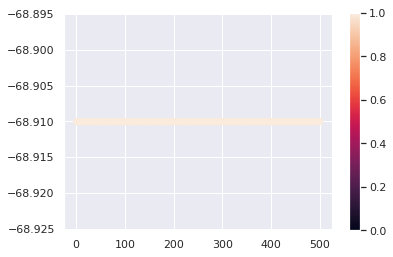

Parameter values
lam: 0.162 [0.146, 0.18]

I1T_lin


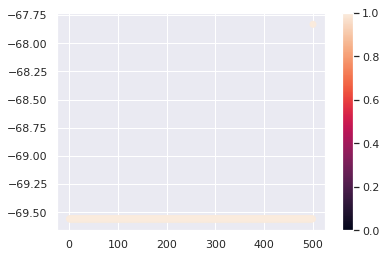

Parameter values
lam0: 0.218 [0.165, 0.288]
lam100: 0.103 [0.0622, 0.171]

I1T_step


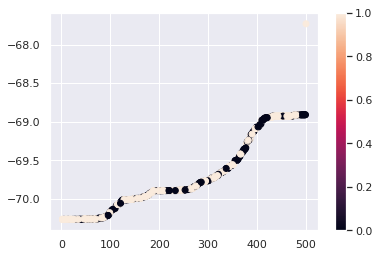

Parameter values
lam2: 0.268 [0.177, 0.405]
t_step: -1.89195 +- 0.10035

IP_l2l4


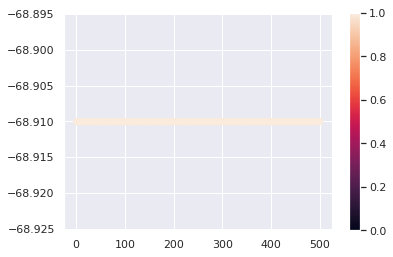

Parameter values
lam2: 0.162 [0.146, 0.18]

IP_l2l4_step


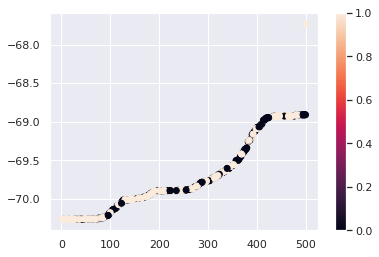

Parameter values
lam1: 0.268 [0.177, 0.405]
lam2: 0.151 [0.136, 0.167]
t_step: 25.4727 +- 0.687905

IP_l40


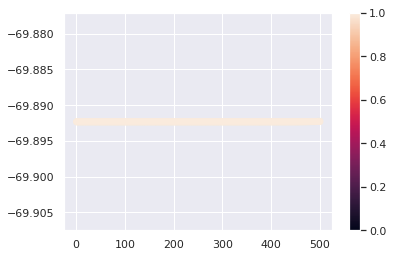

Parameter values
lam2: 0.217 [0.197, 0.239]

IP_l40_lin


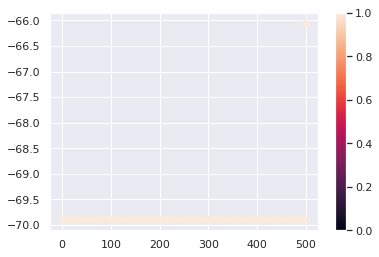

Parameter values
lam0: 0.211 [0.154, 0.289]
lam100: 0.223 [0.165, 0.3]

IP_l40_step


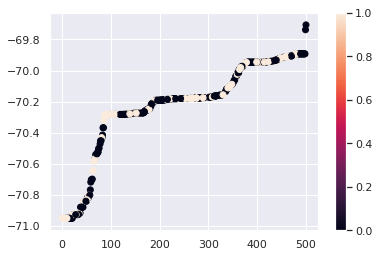

Parameter values
lam1: 0.185 [0.163, 0.209]
lam2: 0.267 [0.221, 0.322]
t_step: 50.9458 +- 0.00544739

IPd


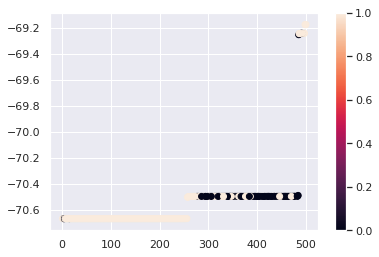

Parameter values
lam2: 0.32 [0.202, 0.505]
lam4: 0.112 [0.0945, 0.133]
k24: 1.93e-10 [0, inf]
k42: 0.1 [0.00295, 3.39]



,loglike,k,n,cAIC
IP_l40,69.892312,2.0,27.0,-135.284624
I1T_step,70.265033,3.0,27.0,-133.486587
IP_l2l4,68.910048,2.0,27.0,-133.320096
I1,68.910048,2.0,27.0,-133.320096
IP_l40_lin,69.896657,3.0,27.0,-132.749835
IP_l40_step,70.950569,4.0,27.0,-132.082955
I1T_lin,69.558455,3.0,27.0,-132.073432
IP_l2l4_step,70.265033,4.0,27.0,-130.711883
IPd,70.665380,5.0,27.0,-128.473616


In [207]:
dataset = 'hepatocytes_nopatho'
for modelname, result in multistart_result[dataset].items():
    summarise(result)
results.sort_values('cAIC')

Plot lam2 for `IPl`

In [52]:
d2, d4, k24, k42 = np.exp(multistart_result['hepatocytes']['IPl'].sort_values('fval').query('valid').iloc[0]['values'])
t = np.linspace(0, 85)
lam2 = -((2*k42 - d2*ploidy(t) - k24*ploidy(t) - 2*k42*ploidy(t) - sp.misc.derivative(ploidy, t, 0.001))/ploidy(t))
plt.plot(t, lam2)

KeyError: 'IPl'

# Weights and Evidence ratio

In [208]:
final_results = results.copy()

In [209]:
final_results['delta'] = final_results['cAIC'] - final_results['cAIC'].min() 
final_results['w'] = np.exp(-0.5*final_results['delta']) / np.exp(-0.5*final_results['delta']).sum()
final_results['ER'] = final_results['w'].max() / final_results['w']
final_results.sort_values('cAIC')

,loglike,k,n,cAIC,delta,w,ER
IP_l40,69.892312,2.0,27.0,-135.284624,0.000000,0.336159,1.000000
I1T_step,70.265033,3.0,27.0,-133.486587,1.798037,0.136806,2.457190
IP_l2l4,68.910048,2.0,27.0,-133.320096,1.964528,0.125879,2.670495
I1,68.910048,2.0,27.0,-133.320096,1.964528,0.125879,2.670495
IP_l40_lin,69.896657,3.0,27.0,-132.749835,2.534788,0.094650,3.551585
IP_l40_step,70.950569,4.0,27.0,-132.082955,3.201668,0.067813,4.957166
I1T_lin,69.558455,3.0,27.0,-132.073432,3.211192,0.067491,4.980827
IP_l2l4_step,70.265033,4.0,27.0,-130.711883,4.572740,0.034165,9.839158
IPd,70.665380,5.0,27.0,-128.473616,6.811007,0.011157,30.129467


In [210]:
final_results = results.loc[['IP', 'IP_dlk0',
       'IP_dlk0_step', 'IP_l40', 'IP_l40_dd_k420']]

In [ ]:
final_results['delta'] = final_results['cAIC'] - final_results['cAIC'].min() 
final_results['w'] = np.exp(-0.5*final_results['delta']) / np.exp(-0.5*final_results['delta']).sum()
final_results['ER'] = final_results['w'].max() / final_results['w']
final_results.sort_values('cAIC')

# Some plots

## For Paula

### Hepatocytes

#### Results of IP_dlk0_step

In [ ]:
res = multistart_result['hepatocytes']['IP_dlk0_step'].query('valid').sort_values('fval').iloc[0]

In [ ]:
p_val = res['values']
p_errors = res['errors']

##### Model prediction

In [ ]:
df_model = datasets['hepatocytes'].copy()
df_model['predicted dC14'] = IP_dlk0_step(datasets['hepatocytes']['Dbirth'],
                                        datasets['hepatocytes']['Dcoll'],
                                        *p_val)
df_model['predicted Sigma'] = Sigma(p_val, IP_dlk0_step, datasets['hepatocytes'])

##### Step function

In [ ]:
np.random.seed(42)
n= 10000
p_sample = np.random.normal(p_val, p_errors, size=(n, 3)).T

In [ ]:
df_step = pd.DataFrame()
df_step['age (years)'] = np.linspace(0, 100, 100)
df_step['turnover_rate (1/year)'] = np.exp(loglam_step(df_step['age (years)'], *p_val))
vector = np.exp(np.vectorize(loglam_step, signature='(n),(),(),()->(n)')(df_step['age (years)'], p_sample[0], p_sample[1], p_sample[2]))
for q in [0.025, 0.975]:
    df_step[f'{q*100}% quantile'] = np.quantile(vector, q, axis=0)

##### Export

In [ ]:
with pd.ExcelWriter('../../results/step_model_results.xlsx') as writer:  # doctest: +SKIP
    df_model.to_excel(writer, sheet_name='model prediction')
    df_step.to_excel(writer, sheet_name='step_function')

In [ ]:
sns.set_context('notebook')

In [ ]:
fig, ax = plt.subplots()
tt = np.linspace(1930, 2000)
ax.plot(tt, C_atm(tt))
ax.plot('Dbirth', 'd14C', data=df_model, ls='None', marker='.')
ax.errorbar(df_model['Dbirth'], df_model['predicted dC14'], df_model['predicted Sigma'], ls='None', marker='.')
plt.xlabel('calendar year')
plt.ylabel('d14C')
plt.ylim(-0.05, 0.15)
plt.legend()
plt.show()

In [ ]:
plt.plot('age (years)', 'turnover_rate (1/year)', data=df_step, label='estimate')
plt.plot('age (years)', '2.5% quantile', data=df_step, label='95% CI', c='C0', ls='--')
plt.plot('age (years)', '97.5% quantile', data=df_step, c='C0', ls='--', label='')
plt.xlabel('age (years)')
plt.ylabel('turnover rate (1/years)')
plt.legend()
plt.show()

### Non-Hepatocytes

#### Results of I1

In [ ]:
dataset = 'non-hepatocytes'

In [ ]:
modelname = 'I1'

In [ ]:
res = multistart_result[dataset][modelname].query('valid').sort_values('fval').iloc[0]

In [ ]:
p_val = res['values']
p_errors = res['errors']

##### Model prediction

In [ ]:
df_model = datasets[dataset].copy()
df_model['predicted dC14'] = eval(modelname)(datasets[dataset]['Dbirth'],
                                        datasets[dataset]['Dcoll'],
                                        *p_val)
df_model['predicted Sigma'] = Sigma(p_val, eval(modelname), datasets[dataset])

##### Export

In [ ]:
with pd.ExcelWriter(f'../../results/{modelname}_{dataset}_results.xlsx') as writer:  # doctest: +SKIP
    df_model.to_excel(writer, sheet_name='model prediction')

In [ ]:
sns.set_context('notebook')

In [ ]:
fig, ax = plt.subplots()
tt = np.linspace(1930, 2000)
ax.plot(tt, C_atm(tt))
ax.plot('Dbirth', 'd14C', data=df_model, ls='None', marker='.')
ax.errorbar(df_model['Dbirth'], df_model['predicted dC14'], df_model['predicted Sigma'], ls='None', marker='.')
plt.xlabel('calendar year')
plt.ylabel('d14C')
plt.ylim(-0.05, 0.15)
plt.legend()
plt.show()

In [ ]:
plt.plot('age (years)', 'turnover_rate (1/year)', data=df_step, label='estimate')
plt.plot('age (years)', '2.5% quantile', data=df_step, label='95% CI', c='C0', ls='--')
plt.plot('age (years)', '97.5% quantile', data=df_step, c='C0', ls='--', label='')
plt.xlabel('age (years)')
plt.ylabel('turnover rate (1/years)')
plt.legend()
plt.show()

## Plot I1T_step

In [ ]:
fig, ax = plt.subplots()
tt = np.linspace(0, 100, 100)
ax.plot(tt, )
ax.plot(tt, res_I1T_step.loc[res_I1T_lin['fval'].idxmin(), 'values']
        np.exp(loglam_step(tt, 
                           *res_I1T_step.loc[res_I1T_lin['fval'].idxmin(), 'values'])
              ),
        label='step'
       )
ax.set_xlabel('age of person')
ax.set_ylabel('turnover rate (per year)')
ax.legend()
fig.savefig('../../results/plots/sigmoidal_solution.pdf', dpi=300, bboc_inches='tight')
plt.show()

In [ ]:
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 4))
# time = sp.linspace(1930, 2018, 30)

# ax.plot(time, C_atm(time), label='atmospheric $^{14}$C concentration')

# ax.plot(exp_data['Dbirth'], exp_data['d14C'], ls='None',
#         marker='o', label='C14 in DNA', zorder=10)

# for coll in [2005, 2010, 2015, 2020]:
#     ax.plot(time[time<coll-5], 
#             I1T_step(time[time<coll-5], coll, *M_I1T_step.values.values()), label=f'Model (Collection in {coll})')

# plt.xlim(1930, 2018)
# plt.ylim(-0.12, 0.15)

# ax.set_ylabel('$\Delta^{14}$C')

# ax.legend(loc='lower right')
# ax.set_xlabel('Calendar year')

# plt.savefig('../../results/plots/model_prediction_hepatocytes_v1.pdf', bbox_inches='tight', dpi=300)

# plt.show()

In [ ]:
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 4))
# time = sp.linspace(1930, 2018, 30)

# ax.plot(time, C_atm(time), label='atmospheric $^{14}$C concentration')

# ax.plot(exp_data['Dbirth'], exp_data['d14C'], ls='None',
#         marker='o', label='Measured $^{14}$C concentration', zorder=10)

# ax.errorbar(exp_data['Dbirth'],
#            I1T_step(exp_data['Dbirth'], exp_data['Dcoll'], *M_I1T_step.values.values()),
#             Sigma(M_I1T_step.values.values(), I1T_step, exp_data),
#             ls='None', marker='o', label='Best fit'
#            )

# plt.xlim(1930, 2018)
# plt.ylim(-0.05, 0.15)

# ax.set_ylabel('$\Delta^{14}$C')

# ax.legend(loc='lower right')
# ax.set_xlabel('Calendar year')

# plt.savefig('../../results/plots/model_prediction_hepatocytes_v2.pdf', bbox_inches='tight', dpi=300)

# plt.show()

## Plot

In [ ]:
fig, ax = plt.subplots()
tt = np.linspace(0, 100, 100)
ax.plot(tt, 
        lam_lin(tt, *res_I1T_lin.loc[res_I1T_lin['fval'].idxmin(), 'values'])
       )
# ax.plot(tt, res_I1T_step.loc[res_I1T_lin['fval'].idxmin(), 'values'],
#         np.exp(loglam_step(tt, 
#                            *res_I1T_step.loc[res_I1T_lin['fval'].idxmin(), 'values'])
#               )
#        )
ax.set_xlabel('age of person')
ax.set_ylabel('turnover rate (per year)')
# fig.savefig('../../results/plots/sigmoidal_solution.pdf', dpi=300, bboc_inches='tight')
plt.show()

## Plot I1, I1T, I1_memory

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
tt = np.linspace(1930, 2020)
ax.plot(tt, np.vectorize(c14_models.C_atm)(tt))
ax.plot(exp_data['Dbirth'], exp_data['d14C'], ls = 'None', marker = 'o')

# ax.errorbar(exp_data['Dbirth']-0.4, 
#             I1(exp_data['Dbirth'].values,
#                exp_data['Dcoll'].values,
#                *res_I1.x
#                ),
#            Sigma(res_I1.x, I1, exp_data),
#            ls='None',
#             marker='s',
#            label = 'I1')

ax.errorbar(exp_data['Dbirth'], 
            I1T_step(exp_data['Dbirth'].values,
                          exp_data['Dcoll'].values,
                          *res_I1T_step.x
                         ),
           0*Sigma(res_I1T_step.x, I1T_step, exp_data),
           ls='None',
            marker='s',
           label = 'I1T_step')

# ax.errorbar(exp_data['Dbirth']+0.4, 
#              I1_memory(exp_data['Dbirth'], 
#                       exp_data['Dcoll'],
#                       *res_I1_memory.x),
#              Sigma(res_I1_memory.x, I1_memory, exp_data),
#              ls = 'None',
#             marker='o',
#            label='I1_memory')


ax.set_ylim((0, 0.12))
ax.legend()
plt.show()

# Other models

## Ploidy model, lam4=0

In [ ]:
@np.vectorize
def IP_l40(Dbirth, Dcoll, loglam2, logk24, logk42):
    lam2 = np.exp(loglam2)
    k24 = np.exp(logk24)
    k42 = np.exp(logk42)
    
    def k24_(t):
        return 0.5 * k24 * ploidy(t-Dbirth) / (1-ploidy(t-Dbirth))
    def k42_(t):
        return 2 * k42 * (1-ploidy(t-Dbirth)) / ploidy(t-Dbirth)
    
    def rhs(t, c):
        c2 = c[0]
        c4 = c[1]
        dtc2 = -(lam2 + k42_(t)) * c2 + k42_(t) * c4 + lam2 * C_atm(t)
        dtc4 = -2*k24_(t) * c4 + k24_(t) * c2 + k24_(t) * C_atm(t)
        return [dtc2, dtc4]

    C_init = C_atm(Dbirth)
    
    sol = sp.integrate.solve_ivp(fun=rhs,
                                 t_span=(Dbirth, Dcoll),
                                 t_eval=[Dcoll],
                                 y0=[C_init, C_init],
                                vectorized=True,
                                max_step=step,
                                first_step=step,
                                rtol=np.inf,
                                atol=np.inf,
                                method='RK45')
    c2, c4 = sol.y[:,0]
    p = ploidy(Dcoll-Dbirth)
    
    return np.average([c2, c4], weights=[p, 2*(1-p)])

## Ploidy model - same death rate

In [ ]:
@np.vectorize
def IP_d(Dbirth, Dcoll, loglam2, loglam4, logk24):
    lam2 = np.exp(loglam2)
    lam4 = np.exp(loglam4)
    k24 = np.exp(logk24)
    
    def k24_(t):
        return 0.5 * k24 * ploidy(t-Dbirth) / (1-ploidy(t-Dbirth))
    def f(t):
        return 2/(2-ploidy(t-Dbirth))*(sp.misc.derivative(ploidy, t-Dbirth, 0.001)/ploidy(t-Dbirth) + k24 + (lam2-lam4)*(ploidy(t-Dbirth)-1))
    
    def rhs(t, c):
        c2 = c[0]
        c4 = c[1]
        dtc2 = -(lam2 + f(t)) * c2 + f(t) * c4 + lam2 * C_atm(t)
        dtc4 = -(lam4 + 2*k24_(t)) * c4 + k24_(t) * c2 + (lam4+k24_(t)) * C_atm(t)
        return [dtc2, dtc4]

    C_init = C_atm(Dbirth)
    
    sol = sp.integrate.solve_ivp(fun=rhs,
                                 t_span=(Dbirth, Dcoll),
                                 t_eval=[Dcoll],
                                 y0=[C_init, C_init],
                                vectorized=True,
                                max_step=step,
                                first_step=step,
                                rtol=np.inf,
                                atol=np.inf,
                                method='RK45')
    c2, c4 = sol.y[:,0]
    p = ploidy(Dcoll-Dbirth)
    
    return np.average([c2, c4], weights=[p, 2*(1-p)])

## Ploidy model - same death, division rate

In [ ]:
@np.vectorize
def IP_dl(Dbirth, Dcoll, loglam2, logk24):
    lam2 = np.exp(loglam2)
    lam4 = np.exp(loglam2)
    k24 = np.exp(logk24)
    
    def k24_(t):
        return 0.5 * k24 * ploidy(t-Dbirth) / (1-ploidy(t-Dbirth))
    def f(t):
        return 2/(2-ploidy(t-Dbirth))*(sp.misc.derivative(ploidy, t-Dbirth, 0.001)/ploidy(t-Dbirth) + k24)
    
    def rhs(t, c):
        c2 = c[0]
        c4 = c[1]
        dtc2 = -(lam2 + f(t)) * c2 + f(t) * c4 + lam2 * C_atm(t)
        dtc4 = -(lam4 + 2*k24_(t)) * c4 + k24_(t) * c2 + (lam4+k24_(t)) * C_atm(t)
        return [dtc2, dtc4]

    C_init = C_atm(Dbirth)
    
    sol = sp.integrate.solve_ivp(fun=rhs,
                                 t_span=(Dbirth, Dcoll),
                                 t_eval=[Dcoll],
                                 y0=[C_init, C_init],
                                vectorized=True,
                                max_step=step,
                                first_step=step,
                                rtol=np.inf,
                                atol=np.inf,
                                method='RK45')
    c2, c4 = sol.y[:,0]
    p = ploidy(Dcoll-Dbirth)
    
    return np.average([c2, c4], weights=[p, 2*(1-p)])

## Ploidy model - same death, $\lambda_4=0$

In [ ]:
@np.vectorize
def IP_dl40(Dbirth, Dcoll, loglam2, logk24):
    lam2 = np.exp(loglam2)
    lam4 = 0
    k24 = np.exp(logk24)
    
    def k24_(t):
        return 0.5 * k24 * ploidy(t-Dbirth) / (1-ploidy(t-Dbirth))
    def f(t):
        return 2/(2-ploidy(t-Dbirth))*(sp.misc.derivative(ploidy, t-Dbirth, 0.001)/ploidy(t-Dbirth) + k24)
    
    def rhs(t, c):
        c2 = c[0]
        c4 = c[1]
        dtc2 = -(lam2 + f(t)) * c2 + f(t) * c4 + lam2 * C_atm(t)
        dtc4 = -(lam4 + 2*k24_(t)) * c4 + k24_(t) * c2 + (lam4+k24_(t)) * C_atm(t)
        return [dtc2, dtc4]

    C_init = C_atm(Dbirth)
    
    sol = sp.integrate.solve_ivp(fun=rhs,
                                 t_span=(Dbirth, Dcoll),
                                 t_eval=[Dcoll],
                                 y0=[C_init, C_init],
                                vectorized=True,
                                max_step=step,
                                first_step=step,
                                rtol=np.inf,
                                atol=np.inf,
                                method='RK45')
    c2, c4 = sol.y[:,0]
    p = ploidy(Dcoll-Dbirth)
    
    return np.average([c2, c4], weights=[p, 2*(1-p)])

## I1 Memory

In [ ]:
@np.vectorize
def I1_memory(Dbirth, Dcoll, loglam, f, t0):
    lam = np.exp(loglam)
    C1 = c14_models.I1c(Dbirth, Dcoll, lam)
    
    if t0>Dcoll-Dbirth:
        return C1
    else:
        C0 = c14_models.I1c(Dbirth, Dbirth + t0, lam)
        return f*C1 + (1-f)*C0

## I1 Memory Interval

In [ ]:
@np.vectorize
def I1_memory_interval(Dbirth, Dcoll, loglam, f, t0, t1):
    if f >= 1:
        f = 1
    if t0 < 0.1:
        t0 = 0.1
    if t1 < 0.1:
        t1 = 0.1
    lam = np.exp(loglam)
    C1 = c14_models.I1c(Dbirth, Dcoll, lam)
    C0 = C1
    
    if Dbirth + t0 >= Dcoll:
        C0 = C1
    elif Dbirth + t0 + t1 >= Dcoll:
        C0 = np.mean(np.vectorize(c14_models.I1c)(Dbirth, np.arange(Dbirth + t0, Dcoll, 1), lam))
    else:
        C0 = np.mean(np.vectorize(c14_models.I1c)(Dbirth, np.arange(Dbirth + t0, Dbirth + t0 + t1, 1), lam))
    return f*C1 + (1-f)*C0

## I1T_sigmoid

In [ ]:
I1T = c14_models.I1T

In [ ]:
@np.vectorize
def I1T_sigmoid(Dbirth, Dcoll, loglam1, loglam2, t_step, n):
    lam1 = np.exp(loglam1)
    lam2 = np.exp(loglam2)
    
    if n > 20:
        n = 20
    if n < 0.5:
        n = 0.5
    def lam_sigmoid(t, lam1, lam2, t_step, n):
        return lam1 + (lam2 - lam1) * (t-Dbirth)**n / (t_step**n + (t-Dbirth)**n)
    
    return I1T(Dbirth, Dcoll, lam_sigmoid, t_eval=np.linspace(Dbirth, Dcoll), lam_arg=(lam1, lam2, t_step, n))[1][-1]

## I1T_linear

In [ ]:
I1T = c14_models.I1T

In [ ]:
@np.vectorize
def I1T_linear(Dbirth, Dcoll, loglam0, r):
    lam0 = np.exp(loglam0)
    r = np.tanh(tanr)
        
    def lam_linear(t, lam0, r):
        if lam0 + r*(t-Dbirth) > 0:
            return lam0 + r*t
        else:
            return 0
    
    return I1T(Dbirth, Dcoll, lam_linear, t_eval=np.linspace(Dbirth, Dcoll), lam_arg=(lam0, r))[1][-1]

## I1T_transient

In [ ]:
@np.vectorize
def I1T_transient(Dbirth, Dcoll, loglam1, loglam2, t_on, t_off):
    lam1 = np.exp(loglam1)
    lam2 = np.exp(loglam2)
    
    def lam_transient(t, lam1, lam2, t_on, t_off):
        return np.where(np.logical_or(t < Dbirth + t_on,
                                      t > Dbirth + t_on + t_off),
                        lam1, 
                        lam2)
    
    return I1T(Dbirth, Dcoll, lam_transient, 
               t_eval=np.linspace(Dbirth, Dcoll), 
               lam_arg=(lam1, lam2, t_on, t_off)
              )[1][-1]

## I2

In [ ]:
@np.vectorize
def I2(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.I2(Dbirth, Dcoll, lam, f, 
                         t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## IK

In [ ]:
@np.vectorize
def IK(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.IK(Dbirth, Dcoll, lam, f, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## IL

In [ ]:
@np.vectorize
def IL(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.IL(Dbirth, Dcoll, lam, f, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Scenario IX2p

In [ ]:
@np.vectorize
def IX2p(Dbirth, Dcoll, dloglam1, dloglam2, f1):
    dlam1 = np.exp(dloglam1)
    dlam2 = np.exp(dloglam2)
    
    f2 = 1-f1
    
    return c14_models.IX(Dbirth, Dcoll, [dlam1, dlam2], [f1, f2],
                        t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

In [ ]:
results.sort_values('cAIC')